Philippe Joly
MAIS 202

This is an implementation of Support Vector Regression (SVR) on Electrical Power Output based on the Weather in Quebec

# Imports

In [1]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import pickle

# Data Retrieval

In [2]:
train = pd.read_csv('../../data/train_static.csv')
val = pd.read_csv('../../data/val_static.csv')
test = pd.read_csv('../../data/test_static.csv')

# Data Preprocessing

In [3]:
train.head()

,Date/Time (UTC),Temp (°C),Year,Month,Day,Hour,Day of Week,Population,Average Power Output (MW)
0,2019-01-01 01:00:00,-3.129954,2019,1,1,1,2,8430363,23762.55
1,2019-01-01 02:00:00,-3.200603,2019,1,1,2,2,8430363,23830.23
2,2019-01-01 03:00:00,-2.736991,2019,1,1,3,2,8430363,23608.07
3,2019-01-01 04:00:00,-1.625532,2019,1,1,4,2,8430363,23562.48
4,2019-01-01 05:00:00,0.933287,2019,1,1,5,2,8430363,23546.16


In [4]:
train['Date/Time (UTC)'] = pd.to_datetime(train['Date/Time (UTC)'])

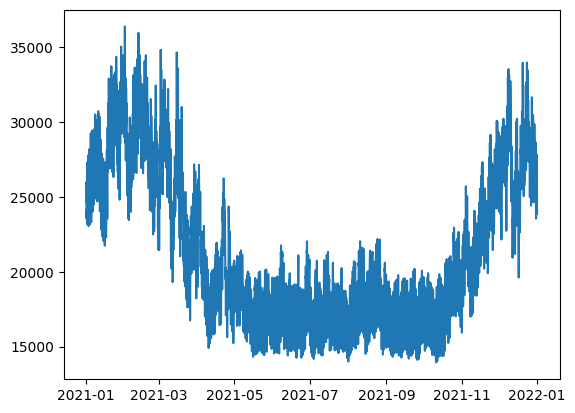

In [5]:
plt.plot(train[train['Date/Time (UTC)'].dt.year==2021]['Date/Time (UTC)'], train[train['Date/Time (UTC)'].dt.year==2021]['Average Power Output (MW)'])

In [6]:

train.drop(columns=['Date/Time (UTC)','Year'], inplace=True)
val.drop(columns=['Date/Time (UTC)','Year'], inplace=True)
test.drop(columns=['Date/Time (UTC)','Year'], inplace=True)

X = train.drop(columns=["Average Power Output (MW)"]).values
y = train["Average Power Output (MW)"].values

X_val = val.drop(columns=["Average Power Output (MW)"]).values
y_val = val["Average Power Output (MW)"].values

X_test = test.drop(columns=["Average Power Output (MW)"]).values
y_test = test["Average Power Output (MW)"].values

In [7]:
y = y.reshape(len(y), 1)
y_val = y_val.reshape(len(y_val), 1)
y_test = y_test.reshape(len(y_test), 1)

x_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)

X = x_scaler.transform(X)
y = y_scaler.transform(y)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

y = y.reshape(y.shape[0])
y_val = y_val.reshape(y_val.shape[0])
y_test = y_test.reshape(y_test.shape[0])

# Hyper-Parameter Tuning

In [20]:
svr_sig = SVR()

In [9]:
opt_params=[{
    'C': np.logspace(-4,4,10),
    'gamma': np.logspace(-6,1,10),
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'coef0': [0.0, 0.1, 0.5, 1.0],
    'kernel': ['sigmoid','rbf'],
    'max_iter': [100, 1000, 2000]
}]

In [10]:
clf = BayesSearchCV(svr_sig, search_spaces=opt_params, cv=3, verbose=False, n_jobs=-1, n_iter=200)
best_clf = clf.fit(X,y)

c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\opt

In [11]:
results_sig = pd.DataFrame(best_clf.cv_results_).sort_values(by="rank_test_score", ascending=True)

In [12]:
results_sig.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,param_epsilon,param_gamma,param_kernel,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,2.206541,0.027789,0.594489,0.016260,2.782559,0.1,0.1,0.001292,sigmoid,981,"{'C': 2.782559402207126, 'coef0': 0.1, 'epsilo...",0.592964,0.684393,0.675586,0.650981,0.041181,1
20,2.464325,0.059780,0.762353,0.005298,0.046416,1.0,0.01,0.046416,sigmoid,1000,"{'C': 0.046415888336127774, 'coef0': 1.0, 'eps...",0.586261,0.548281,0.502118,0.545553,0.034405,2
16,0.960419,0.008043,0.265672,0.006799,0.046416,0.1,0.1,0.007743,sigmoid,418,"{'C': 0.046415888336127774, 'coef0': 0.1, 'eps...",0.316302,-0.052249,0.224379,0.162811,0.156632,3
21,2.355302,0.077217,0.758014,0.026852,0.005995,1.0,0.01,0.046416,sigmoid,1000,"{'C': 0.005994842503189409, 'coef0': 1.0, 'eps...",0.172312,-0.103730,0.128590,0.065724,0.121144,4
18,2.320591,0.030524,0.749300,0.016334,0.005995,1.0,0.01,0.046416,sigmoid,1000,"{'C': 0.005994842503189409, 'coef0': 1.0, 'eps...",0.172312,-0.103730,0.128590,0.065724,0.121144,4


In [13]:
best_clf.best_score_

0.650980823768682

In [21]:
model_ls = []
err = []
for i in range(10):
    err.append([])
    model = SVR(**results_sig['params'].iloc[i])
    model.fit(X, y)
    y_pred = model.predict(X_val)
    err[i].append(mean_squared_error(y_val, y_pred))
    err[i].append(r2_score(y_val, y_pred))
    err[i].append(mean_absolute_error(y_val, y_pred))
    model_ls.append(model)

OrderedDict([('C', 2.782559402207126),
             ('coef0', 0.1),
             ('epsilon', 0.1),
             ('gamma', 0.001291549665014884),
             ('kernel', 'sigmoid'),
             ('max_iter', 981)])

In [ ]:
err

In [14]:
# svr_rbf = SVR()

In [15]:
# opt_params=[{
#     'C': np.logspace(-4,4,10),
#     'gamma': np.logspace(-6,1,10),
#     'epsilon': [0.01, 0.1, 0.2, 0.5],
#     'tol': [1e-3, 1e-4, 1e-5],
#     'kernel': ['rbf'],
#     'max_iter': [100,1000]
# }]

In [16]:
# clf_rbf = BayesSearchCV(svr_rbf, search_spaces=opt_params, cv=3, verbose=False, n_jobs=-1, n_iter=200)
# best_clf_rbf = clf_rbf.fit(X,y)

c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\opt

In [17]:
# results_rbf = pd.DataFrame(best_clf_rbf.cv_results_).sort_values(by="rank_test_score", ascending=True, ignore_index=True)

In [18]:

# for i in range(100):
#     print(results_rbf['params'].iloc[i])
# results_rbf.tail(25)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
175,4.258480,0.043381,2.943121,0.026321,2.782559,0.5,0.007743,rbf,1000,0.00001,"{'C': 2.782559402207126, 'epsilon': 0.5, 'gamm...",0.872920,0.842929,0.795692,0.837180,0.031789,173
176,2.577312,0.061012,2.457147,0.022665,2.782559,0.5,0.007743,rbf,1000,0.00001,"{'C': 2.782559402207126, 'epsilon': 0.5, 'gamm...",0.872920,0.842929,0.795692,0.837180,0.031789,173
177,3.058042,0.027718,2.820662,0.030243,2.782559,0.5,0.007743,rbf,1000,0.00001,"{'C': 2.782559402207126, 'epsilon': 0.5, 'gamm...",0.872920,0.842929,0.795692,0.837180,0.031789,173
178,2.082745,0.023694,2.471234,0.039339,2.782559,0.5,0.007743,rbf,1000,0.00001,"{'C': 2.782559402207126, 'epsilon': 0.5, 'gamm...",0.872920,0.842929,0.795692,0.837180,0.031789,173
179,2.345547,0.022538,2.668602,0.022114,2.782559,0.5,0.007743,rbf,1000,0.00001,"{'C': 2.782559402207126, 'epsilon': 0.5, 'gamm...",0.872920,0.842929,0.795692,0.837180,0.031789,173
180,2.525597,0.031636,2.311718,0.018914,2.782559,0.5,0.007743,rbf,1000,0.00001,"{'C': 2.782559402207126, 'epsilon': 0.5, 'gamm...",0.872920,0.842929,0.795692,0.837180,0.031789,173
181,2.898775,0.055167,2.462187,0.039986,2.782559,0.5,0.007743,rbf,1000,0.00001,"{'C': 2.782559402207126, 'epsilon': 0.5, 'gamm...",0.872920,0.842929,0.795692,0.837180,0.031789,173
182,2.398970,0.031994,2.431607,0.021861,21.544347,0.5,0.000215,rbf,1000,0.00001,"{'C': 21.54434690031882, 'epsilon': 0.5, 'gamm...",0.811315,0.706933,0.791811,0.770020,0.045314,183
183,0.420347,0.014634,0.487559,0.023129,0.359381,0.5,0.278256,rbf,217,0.001,"{'C': 0.3593813663804626, 'epsilon': 0.5, 'gam...",0.722811,0.887870,0.610298,0.740326,0.113993,184
184,2.353897,0.088727,2.527296,0.054681,21.544347,0.2,0.001292,rbf,1000,0.001,"{'C': 21.54434690031882, 'epsilon': 0.2, 'gamm...",0.713882,0.664703,0.784369,0.720985,0.049111,185


In [19]:
# best_clf_rbf.best_score_

0.8491786355617624

# Model and Training

# Testing